In [8]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import time
from numpy.polynomial.legendre import leggauss

In [9]:
# -----------------------------
# Configuration
# -----------------------------
x = sp.Symbol('x')
eps = 1e-12

# -----------------------------
# Fonction de base
# -----------------------------
f_base_sym = 1 + x**2
f_base = sp.lambdify(x, f_base_sym, 'numpy')

# -----------------------------
# Définition des 4 INTÉGRANDES (brutes, avec poids)
# -----------------------------
def f_neutre(x_val):
    """Intégrande NEUTRE: F(x)"""
    return f_base(x_val)

def f_type_chebyshev(x_val):
    """Intégrande CHEBYSHEV: F(x)/√(1-x²)"""
    x_val = np.clip(x_val, -1 + eps, 1 - eps)
    return f_base(x_val) / np.sqrt(1 - x_val**2)

def f_type_laguerre(x_val):
    """Intégrande LAGUERRE: exp(-x)·F(x)"""
    return f_base(x_val) * np.exp(-x_val)

def f_type_combine(x_val):
    """Intégrande COMBINÉ: exp(-x)·F(x)/√(1-x²)"""
    x_val = np.clip(x_val, -1 + eps, 1 - eps)
    return f_base(x_val) * np.exp(-x_val) / np.sqrt(1 - x_val**2)

In [10]:
# -----------------------------
# Méthodes d'intégration
# -----------------------------
def gauss_legendre(n, a, b, func):
    """Gauss-Legendre: intègre func(x) sur [a,b]"""
    y_i, w_i = leggauss(n)
    t = 0.5 * (b - a) * y_i + 0.5 * (a + b)
    return 0.5 * (b - a) * np.sum(w_i * func(t))

def gauss_laguerre(n, func):
    """Gauss-Laguerre: intègre func(x)*exp(-x) sur [0,∞)"""
    x_i, w_i = np.polynomial.laguerre.laggauss(n)
    return np.sum(w_i * func(x_i))

def gauss_chebyshev(n, func):
    """Gauss-Chebyshev: intègre func(x)/sqrt(1-x²) sur [-1,1]"""
    x_i = np.cos((2 * np.arange(1, n + 1) - 1) * np.pi / (2 * n))
    w_i = np.pi / n
    return w_i * np.sum(func(x_i))

import numpy as np

def simpson(a, b, n, f):
    
    # On a besoin de 2n intervalles
    h = (b - a) / (2 * n)

    # Points z_i
    z = np.linspace(a, b, 2 * n + 1)
    fz = f(z)

    # Sommes
    somme_impairs = np.sum(fz[1:2*n:2])     # z1, z3, z5, ...
    somme_pairs   = np.sum(fz[2:2*n-1:2])   # z2, z4, z6... sauf le dernier

    return (h / 3) * (fz[0] + 4 * somme_impairs + 2 * somme_pairs + fz[-1])

def integrate_spline_quadratique(x_nodes, y_nodes, z0):
    """Spline quadratique avec dérivée initiale z0"""
    n = len(x_nodes)
    z = np.zeros(n)
    z[0] = z0
    for i in range(1, n):
        dx = x_nodes[i] - x_nodes[i-1]
        dy = y_nodes[i] - y_nodes[i-1]
        z[i] = 2 * (dy/dx) - z[i-1]
    I_total = 0.0
    for i in range(n - 1):
        dx = x_nodes[i+1] - x_nodes[i]
        a_coef = 0.5 * (z[i+1] - z[i]) / dx
        I_i = a_coef*(dx**3)/3 + z[i]*(dx**2)/2 + y_nodes[i]*dx
        I_total += I_i
    return I_total

In [11]:
# -----------------------------
# Fonction pour calculer les intégrales exactes
# -----------------------------
def calculer_integrales_exactes(integrande_sym, a, b):
    """
    Calcule CE QUE CHAQUE MÉTHODE CALCULE VRAIMENT
    en tenant compte des poids automatiques
    
    
    """
    # Pour Gauss-Legendre, Simpson, Spline: ∫ f(x) dx
    I_standard = float(sp.integrate(integrande_sym, (x, a, b)))
    
    # Pour Gauss-Chebyshev: ∫ f(x)/√(1-x²) dx sur [-1,1]
    try:
        I_chebyshev = float(sp.integrate(integrande_sym / sp.sqrt(1 - x**2), (x, -1, 1)))
    except:
        I_chebyshev = None
    
    # Pour Gauss-Laguerre: ∫ f(x)·exp(-x) dx sur [0,∞)
    try:
        I_laguerre = float(sp.integrate(integrande_sym * sp.exp(-x), (x, 0, sp.oo)))
    except:
        I_laguerre = None
    
    return {
        'standard': I_standard,
        'chebyshev': I_chebyshev,
        'laguerre': I_laguerre
    }

In [12]:
# -----------------------------
# Fonction de test
# -----------------------------
def test_integration_methods(config, n_values):
    """
    Teste TOUTES les méthodes sur une intégrande
    Chaque méthode est comparée à CE QU'ELLE CALCULE VRAIMENT
    """
    func = config['func']
    a, b = config['a'], config['b']
    I_exacts = config['I_exacts']
    methodes_a_tester = config['methodes']
    
    resultats = {nom: {'erreurs': [], 'temps': [], 'valeurs': []} for nom in methodes_a_tester}
    
    print(f"\n{'─'*85}")
    print(f"RÉSULTATS DÉTAILLÉS")
    print(f"{'─'*85}\n")
    
    for n in n_values:
        print(f"  n = {n}")
        print(f"  {'─'*80}")
        
        # Gauss-Legendre 
        if 'Gauss-Legendre' in methodes_a_tester:
            try:
                start = time.perf_counter()
                val = gauss_legendre(n, a, b, func)
                temps = time.perf_counter() - start
                erreur = abs(val - I_exacts['standard'])
                resultats['Gauss-Legendre']['temps'].append(temps)
                resultats['Gauss-Legendre']['erreurs'].append(erreur)
                resultats['Gauss-Legendre']['valeurs'].append(val)
                print(f"    Gauss-Legendre       : {val:.12f} | Exact: {I_exacts['standard']:.12f} | Err: {erreur:.3e} | T: {temps:.6f}s")
            except Exception as e:
                resultats['Gauss-Legendre']['temps'].append(np.nan)
                resultats['Gauss-Legendre']['erreurs'].append(np.nan)
                resultats['Gauss-Legendre']['valeurs'].append(np.nan)
                print(f"    Gauss-Legendre       : ERREUR")
        
        # Gauss-Chebyshev 
        if 'Gauss-Chebyshev' in methodes_a_tester:
            try:
                start = time.perf_counter()
                val = gauss_chebyshev(n, func)
                temps = time.perf_counter() - start
                if I_exacts['chebyshev'] is not None:
                    erreur = abs(val - I_exacts['chebyshev'])
                    resultats['Gauss-Chebyshev']['erreurs'].append(erreur)
                    print(f"    Gauss-Chebyshev      : {val:.12f} | Exact: {I_exacts['chebyshev']:.12f} | Err: {erreur:.3e} | T: {temps:.6f}s")
                else:
                    resultats['Gauss-Chebyshev']['erreurs'].append(np.nan)
                    print(f"    Gauss-Chebyshev      : {val:.12f} | Exact: NON DEFINI | T: {temps:.6f}s")
                resultats['Gauss-Chebyshev']['temps'].append(temps)
                resultats['Gauss-Chebyshev']['valeurs'].append(val)
            except Exception as e:
                resultats['Gauss-Chebyshev']['temps'].append(np.nan)
                resultats['Gauss-Chebyshev']['erreurs'].append(np.nan)
                resultats['Gauss-Chebyshev']['valeurs'].append(np.nan)
                print(f"    Gauss-Chebyshev      : ERREUR")
        
        # Gauss-Laguerre 
        if 'Gauss-Laguerre' in methodes_a_tester:
            try:
                start = time.perf_counter()
                val = gauss_laguerre(n, func)
                temps = time.perf_counter() - start
                if I_exacts['laguerre'] is not None:
                    erreur = abs(val - I_exacts['laguerre'])
                    resultats['Gauss-Laguerre']['erreurs'].append(erreur)
                    print(f"    Gauss-Laguerre       : {val:.12f} | Exact: {I_exacts['laguerre']:.12f} | Err: {erreur:.3e} | T: {temps:.6f}s")
                else:
                    resultats['Gauss-Laguerre']['erreurs'].append(np.nan)
                    print(f"    Gauss-Laguerre       : {val:.12f} | Exact: NON DEFINI | T: {temps:.6f}s")
                resultats['Gauss-Laguerre']['temps'].append(temps)
                resultats['Gauss-Laguerre']['valeurs'].append(val)
            except Exception as e:
                resultats['Gauss-Laguerre']['temps'].append(np.nan)
                resultats['Gauss-Laguerre']['erreurs'].append(np.nan)
                resultats['Gauss-Laguerre']['valeurs'].append(np.nan)
                print(f"    Gauss-Laguerre       : ERREUR")
        
        # Simpson 
        if 'Simpson' in methodes_a_tester:
            try:
                m = 2 * n
                start = time.perf_counter()
                val = methode_simpson(a, b, m, func)
                temps = time.perf_counter() - start
                erreur = abs(val - I_exacts['standard'])
                resultats['Simpson']['temps'].append(temps)
                resultats['Simpson']['erreurs'].append(erreur)
                resultats['Simpson']['valeurs'].append(val)
                print(f"    Simpson              : {val:.12f} | Exact: {I_exacts['standard']:.12f} | Err: {erreur:.3e} | T: {temps:.6f}s")
            except Exception as e:
                resultats['Simpson']['temps'].append(np.nan)
                resultats['Simpson']['erreurs'].append(np.nan)
                resultats['Simpson']['valeurs'].append(np.nan)
                print(f"    Simpson              : ERREUR")
        
        # Spline quadratique 
        if 'Spline quadratique' in methodes_a_tester:
            try:
                x_nodes = np.linspace(a, b, n + 1)
                y_nodes = func(x_nodes)
                z0 = (y_nodes[1] - y_nodes[0]) / (x_nodes[1] - x_nodes[0])
                start = time.perf_counter()
                val = integrate_spline_quadratique(x_nodes, y_nodes, z0)
                temps = time.perf_counter() - start
                erreur = abs(val - I_exacts['standard'])
                resultats['Spline quadratique']['temps'].append(temps)
                resultats['Spline quadratique']['erreurs'].append(erreur)
                resultats['Spline quadratique']['valeurs'].append(val)
                print(f"    Spline quadratique   : {val:.12f} | Exact: {I_exacts['standard']:.12f} | Err: {erreur:.3e} | T: {temps:.6f}s")
            except Exception as e:
                resultats['Spline quadratique']['temps'].append(np.nan)
                resultats['Spline quadratique']['erreurs'].append(np.nan)
                resultats['Spline quadratique']['valeurs'].append(np.nan)
                print(f"    Spline quadratique   : ERREUR")
        
        print()
    
    return resultats

In [13]:
# -----------------------------
# Fonction de tracé
# -----------------------------
def plot_results(resultats, n_values, nom_integrande):
    """Crée les 2 graphiques: erreurs et temps d'exécution"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    markers = ['o', 's', '^', 'D', 'v']
    
    # Graphique 1: Erreurs avec annotations des valeurs de n
    for i, (nom, data) in enumerate(resultats.items()):
        erreurs_valides = [e for e in data['erreurs'] if not np.isnan(e) and e > 0]
        n_valides = n_values[:len(erreurs_valides)]
        if erreurs_valides:
            ax1.loglog(n_valides, erreurs_valides,
                      marker=markers[i % len(markers)], 
                      color=colors[i % len(colors)],
                      label=nom, linewidth=2.5, markersize=9, alpha=0.8)
            
            # Annoter quelques points avec la valeur de n
            if len(n_valides) > 0:
                # Premier point
                ax1.annotate(f'n={n_valides[0]}', 
                           xy=(n_valides[0], erreurs_valides[0]),
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=8, alpha=0.7, color=colors[i % len(colors)])
                # Dernier point
                if len(n_valides) > 1:
                    ax1.annotate(f'n={n_valides[-1]}', 
                               xy=(n_valides[-1], erreurs_valides[-1]),
                               xytext=(5, 5), textcoords='offset points',
                               fontsize=8, alpha=0.7, color=colors[i % len(colors)])
    
    ax1.set_xlabel('Nombre de points (n)', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Erreur absolue', fontsize=13, fontweight='bold')
    ax1.set_title(f'ERREURS - {nom_integrande}', fontsize=15, fontweight='bold', pad=15)
    ax1.legend(fontsize=10, framealpha=0.9, loc='best')
    ax1.grid(True, alpha=0.3, which='both', linestyle='--')
    
    # Graphique 2: Temps d'exécution
    for i, (nom, data) in enumerate(resultats.items()):
        temps_valides = [t for t in data['temps'] if not np.isnan(t) and t > 0]
        n_valides = n_values[:len(temps_valides)]
        if temps_valides:
            ax2.semilogy(n_valides, temps_valides,
                        marker=markers[i % len(markers)], 
                        color=colors[i % len(colors)],
                        label=nom, linewidth=2.5, markersize=9, alpha=0.8)
    
    ax2.set_xlabel('Nombre de points (n)', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Temps d\'exécution (s)', fontsize=13, fontweight='bold')
    ax2.set_title(f'TEMPS D\'EXÉCUTION - {nom_integrande}', fontsize=15, fontweight='bold', pad=15)
    ax2.legend(fontsize=10, framealpha=0.9, loc='best')
    ax2.grid(True, alpha=0.3, which='both', linestyle='--')
    
    plt.tight_layout()
    filename = f'graphique_{nom_integrande.lower().replace(" ", "_")}.png'
    plt.savefig(filename, dpi=200, bbox_inches='tight')
    print(f"   ✓ Graphiques sauvegardés: {filename}")
    plt.show()

                   COMPARAISON DES MÉTHODES D'INTÉGRATION NUMÉRIQUE                  
Valeurs de n testées: [2, 4, 8, 16, 32, 64]


─────────────────────────────────────────────────────────────────────────────────────
│ 1. INTÉGRANDE NEUTRE: f(x) = F(x) = 1 + x²
│    Intégrale sur [0, 2]
─────────────────────────────────────────────────────────────────────────────────────

─────────────────────────────────────────────────────────────────────────────────────
RÉSULTATS DÉTAILLÉS
─────────────────────────────────────────────────────────────────────────────────────

  n = 2
  ────────────────────────────────────────────────────────────────────────────────
    Gauss-Legendre       : 4.666666666667 | Exact: 4.666666666667 | Err: 0.000e+00 | T: 0.090601s
    Gauss-Chebyshev      : 4.712388980385 | Exact: 4.712388980385 | Err: 0.000e+00 | T: 0.000945s
    Gauss-Laguerre       : 3.000000000000 | Exact: 3.000000000000 | Err: 0.000e+00 | T: 0.001850s
    Simpson              : 4.666666666667 | Ex

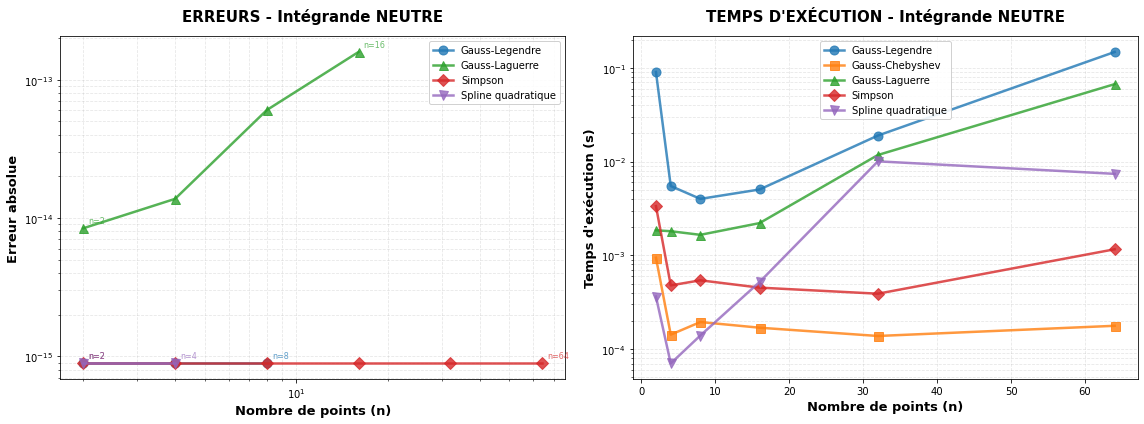


─────────────────────────────────────────────────────────────────────────────────────
│ 2. INTÉGRANDE CHEBYSHEV: f(x) = F(x)/√(1-x²)
│    Intégrale sur [-1, 1]
─────────────────────────────────────────────────────────────────────────────────────

─────────────────────────────────────────────────────────────────────────────────────
RÉSULTATS DÉTAILLÉS
─────────────────────────────────────────────────────────────────────────────────────

  n = 2
  ────────────────────────────────────────────────────────────────────────────────
    Gauss-Legendre       : 3.265986323711 | Exact: 4.712388980385 | Err: 1.446e+00 | T: 0.000898s
    Gauss-Chebyshev      : 6.664324407238 | Exact: inf | Err: inf | T: 0.000155s
    Gauss-Laguerre       : 207110.486556808493 | Exact: NON DEFINI | T: 0.000586s
    Simpson              : 471411.992850738228 | Exact: 4.712388980385 | Err: 4.714e+05 | T: 0.000673s
    Spline quadratique   : 942820.803366348613 | Exact: 4.712388980385 | Err: 9.428e+05 | T: 0.000034s



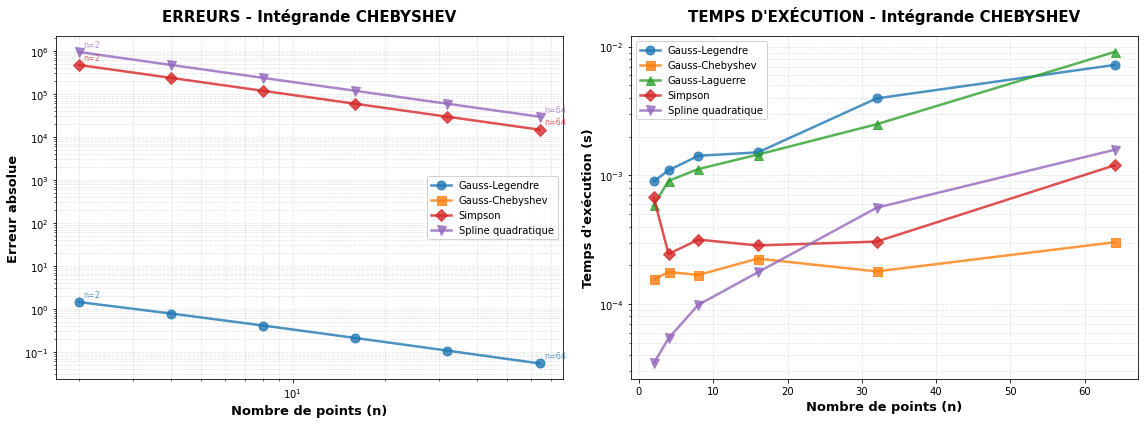


─────────────────────────────────────────────────────────────────────────────────────
│ 3. INTÉGRANDE LAGUERRE: f(x) = exp(-x)·F(x)
│    Intégrale sur [0, ∞)
─────────────────────────────────────────────────────────────────────────────────────

─────────────────────────────────────────────────────────────────────────────────────
RÉSULTATS DÉTAILLÉS
─────────────────────────────────────────────────────────────────────────────────────

  n = 2
  ────────────────────────────────────────────────────────────────────────────────
    Gauss-Legendre       : 3.421297074662 | Exact: 2.994415808639 | Err: 4.269e-01 | T: 0.012026s
    Gauss-Chebyshev      : 5.940399079186 | Exact: 6.179426831801 | Err: 2.390e-01 | T: 0.000165s
    Gauss-Laguerre       : 0.699176150329 | Exact: 0.750000000000 | Err: 5.082e-02 | T: 0.001046s
    Simpson              : 3.218399931429 | Exact: 2.994415808639 | Err: 2.240e-01 | T: 0.000378s
    Spline quadratique   : 2.842219801351 | Exact: 2.994415808639 | Err: 1.522

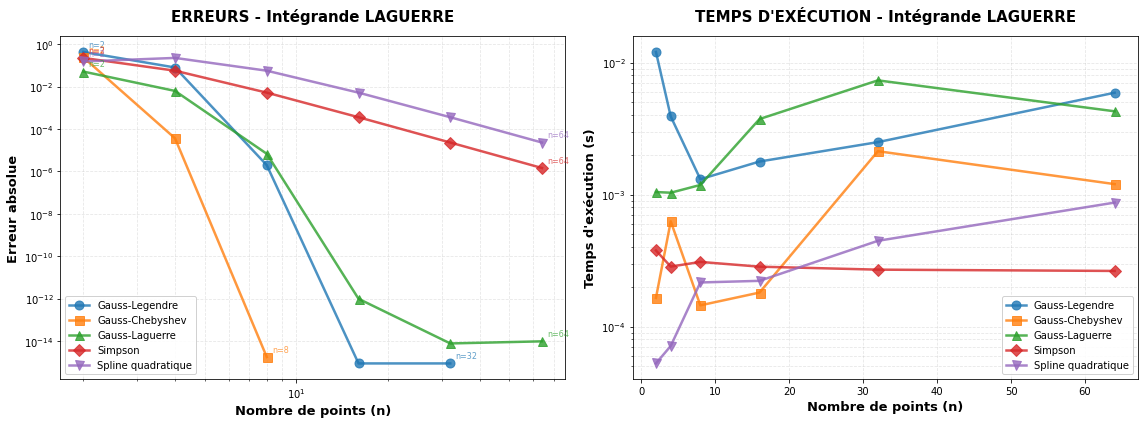


─────────────────────────────────────────────────────────────────────────────────────
│ 4. INTÉGRANDE COMBINÉ: f(x) = exp(-x)·F(x)/√(1-x²)
│    Intégrale sur [-1, 1]
─────────────────────────────────────────────────────────────────────────────────────

─────────────────────────────────────────────────────────────────────────────────────
RÉSULTATS DÉTAILLÉS
─────────────────────────────────────────────────────────────────────────────────────

  n = 2
  ────────────────────────────────────────────────────────────────────────────────
    Gauss-Legendre       : 3.825606691862 | Exact: 6.179426831801 | Err: 2.354e+00 | T: 0.001215s
    Gauss-Chebyshev      : 8.400992943694 | Exact: NON DEFINI | T: 0.000220s
    Gauss-Laguerre       : 76191.957106691785 | Exact: NON DEFINI | T: 0.002336s
    Simpson              : 727425.736617319519 | Exact: 6.179426831801 | Err: 7.274e+05 | T: 0.000373s
    Spline quadratique   : 1454847.799666942330 | Exact: 6.179426831801 | Err: 1.455e+06 | T: 0.000046s

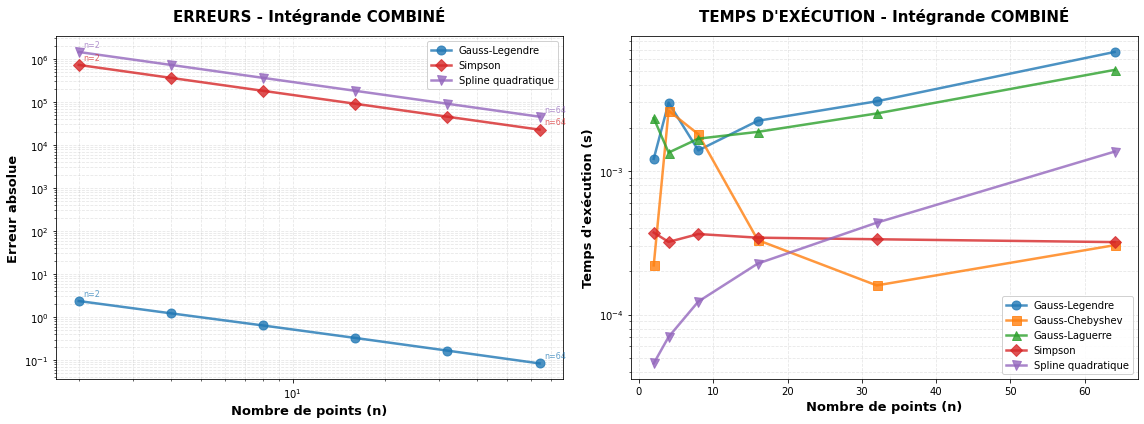

In [14]:
# -----------------------------
# EXÉCUTION: Tests des 4 intégrandes
# -----------------------------
n_values = [2, 4, 8, 16, 32, 64]

print("="*85)
print(" COMPARAISON DES MÉTHODES D'INTÉGRATION NUMÉRIQUE ".center(85))
print("="*85)
print(f"Valeurs de n testées: {n_values}\n")

# ==========================================
# TEST 1: INTÉGRANDE NEUTRE
# ==========================================
print("\n" + "─"*85)
print("│ 1. INTÉGRANDE NEUTRE: f(x) = F(x) = 1 + x²")
print("│    Intégrale sur [0, 2]")
print("─"*85)

a, b = 0, 2
I_exacts_neutre = calculer_integrales_exactes(f_base_sym, a, b)

config_neutre = {
    'func': f_neutre,
    'a': a, 'b': b,
    'I_exacts': I_exacts_neutre,
    'nom': 'Neutre',
    'methodes': ['Gauss-Legendre', 'Gauss-Chebyshev', 'Gauss-Laguerre', 'Simpson', 'Spline quadratique']
}
resultats_neutre = test_integration_methods(config_neutre, n_values)
plot_results(resultats_neutre, n_values, 'Intégrande NEUTRE')

# ==========================================
# TEST 2: INTÉGRANDE CHEBYSHEV
# ==========================================
print("\n" + "─"*85)
print("│ 2. INTÉGRANDE CHEBYSHEV: f(x) = F(x)/√(1-x²)")
print("│    Intégrale sur [-1, 1]")
print("─"*85)

a, b = -1, 1
integrande_cheb_sym = f_base_sym / sp.sqrt(1 - x**2)
I_exacts_cheb = calculer_integrales_exactes(integrande_cheb_sym, a, b)

config_cheb = {
    'func': f_type_chebyshev,
    'a': a, 'b': b,
    'I_exacts': I_exacts_cheb,
    'nom': 'Chebyshev',
    'methodes': ['Gauss-Legendre', 'Gauss-Chebyshev', 'Gauss-Laguerre', 'Simpson', 'Spline quadratique']
}
resultats_cheb = test_integration_methods(config_cheb, n_values)
plot_results(resultats_cheb, n_values, 'Intégrande CHEBYSHEV')

# ==========================================
# TEST 3: INTÉGRANDE LAGUERRE
# ==========================================
print("\n" + "─"*85)
print("│ 3. INTÉGRANDE LAGUERRE: f(x) = exp(-x)·F(x)")
print("│    Intégrale sur [0, ∞)")
print("─"*85)

a, b = 0, 10
integrande_lag_sym = sp.exp(-x) * f_base_sym
I_exacts_lag = calculer_integrales_exactes(integrande_lag_sym, a, b)

config_lag = {
    'func': f_type_laguerre,
    'a': a, 'b': b,
    'I_exacts': I_exacts_lag,
    'nom': 'Laguerre',
    'methodes': ['Gauss-Legendre', 'Gauss-Chebyshev', 'Gauss-Laguerre', 'Simpson', 'Spline quadratique']
}
resultats_lag = test_integration_methods(config_lag, n_values)
plot_results(resultats_lag, n_values, 'Intégrande LAGUERRE')

# ==========================================
# TEST 4: INTÉGRANDE COMBINÉ
# ==========================================
print("\n" + "─"*85)
print("│ 4. INTÉGRANDE COMBINÉ: f(x) = exp(-x)·F(x)/√(1-x²)")
print("│    Intégrale sur [-1, 1]")
print("─"*85)

a, b = -1, 1
integrande_comb_sym = sp.exp(-x) * f_base_sym / sp.sqrt(1 - x**2)
I_exacts_comb = calculer_integrales_exactes(integrande_comb_sym, a, b)

config_comb = {
    'func': f_type_combine,
    'a': a, 'b': b,
    'I_exacts': I_exacts_comb,
    'nom': 'Combinée',
    'methodes': ['Gauss-Legendre', 'Gauss-Chebyshev', 'Gauss-Laguerre', 'Simpson', 'Spline quadratique']
}
resultats_comb = test_integration_methods(config_comb, n_values)
plot_results(resultats_comb, n_values, 'Intégrande COMBINÉ')


